In [1]:
import librosa

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math

In [113]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras

In [53]:
root_logdir = os.path.join(os.curdir, "wave_net_model_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [12]:
def get_paths_and_labels(audio_directory_path):
    class_names = os.listdir(audio_directory_path)
    class_names.remove('.DS_Store')
    label_class_dict = {num:class_ for num, class_ in enumerate(class_names)}
    
    audio_paths = []
    labels = []

    for label, name in enumerate(class_names):
        dir_path = os.path.join(audio_directory_path, name)
        full_paths = [os.path.join(dir_path, filename) for filename in os.listdir(dir_path)]
        audio_paths += full_paths
        labels += [label] * len(full_paths)
    
    return audio_paths, labels, label_class_dict

In [13]:
def path_to_audio(path):
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, desired_samples=16000*27)
    return audio

In [14]:
def create_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

In [15]:
batch_size = 16

train_audio_paths, train_labels, train_label_class_dict = get_paths_and_labels("../data/recordings/train_set")
train_ds = create_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=len(train_ds)).batch(batch_size)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

test_audio_paths, test_labels, test_label_class_dict = get_paths_and_labels("../data/recordings/test_set")
test_ds = create_dataset(test_audio_paths, test_labels)
test_ds = test_ds.shuffle(buffer_size=len(test_ds)).batch(batch_size)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [26]:
import librosa

def get_white_noise(signal,SNR) :
    #RMS value of signal
    RMS_s=math.sqrt(np.mean(signal**2))
    #RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    #Additive white gausian noise. Thereore mean=0
    #Because sample length is large (typically > 40000)
    #we can use the population formula for standard daviation.
    #because mean=0 STD=RMS
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

#given a signal, noise (audio) and desired SNR, this gives the noise (scaled version of noise input) that gives the desired SNR
def get_noise_from_sound(signal,noise,SNR):
    RMS_s=math.sqrt(np.mean(signal**2))
    #required RMS of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    
    #current RMS of noise
    RMS_n_current=math.sqrt(np.mean(noise**2))
    noise=noise*(RMS_n/RMS_n_current)
    
    return noise

#***convert complex np array to polar arrays (2 apprays; abs and angle)
def to_polar(complex_ar):
    return np.abs(complex_ar),np.angle(complex_ar)

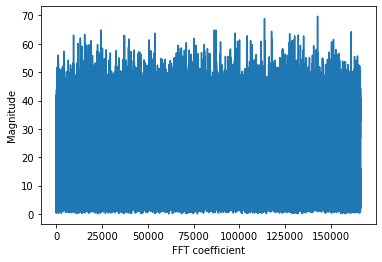

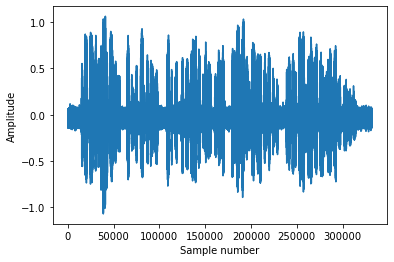

In [44]:
signal_file='../data/recordings/wav_16khz_test/afrikaans1copy.wav'
signal, sr = librosa.load(signal_file, sr=16000)
signal=np.interp(signal, (signal.min(), signal.max()), (-1, 1))
noise=get_white_noise(signal,SNR=15)
#analyze the frequency components in the signal
X=np.fft.rfft(noise)
radius,angle=to_polar(X)
plt.plot(radius)
plt.xlabel("FFT coefficient")
plt.ylabel("Magnitude")
plt.show()
signal_noise=signal+noise
plt.plot(signal_noise)
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.show()

In [8]:
filepath = '../data/recordings/train_set/english/english2.wav'
wav, sr = librosa.load(filepath, sr=16000)
ipd.Audio(wav, rate=sr)

In [17]:
np.random.randint(-2,3)*.001

0.002

In [13]:
import IPython.display as ipd
import librosa

In [117]:
filepath = '../data/recordings/wav_16khz_test/afrikaans1copy.wav'
wav, sr = librosa.load(filepath, sr=16000)
new_wav = wav + 0.006*np.random.normal(0,1,len(wav))
new_wav = np.roll(new_wav, np.random.randint(25000, 150000))
new_wav = librosa.effects.time_stretch(new_wav,np.random.randint(79,91)*.01)
new_wav = librosa.effects.pitch_shift(new_wav, sr, n_steps=np.random.choice([np.random.randint(-25,-9)*.1, np.random.randint(10,26)*.1]))
ipd.Audio(new_wav, rate=sr)

In [80]:
filepath = '../data/recordings/wav_16khz_test/afrikaans1copy.wav'
wav, sr = librosa.load(filepath, sr=16000)
wav_pitch_sf = librosa.effects.pitch_shift(wav,sr,n_steps=-2)
ipd.Audio(wav_pitch_sf,rate=sr)

In [10]:
filepath = '../data/recordings/wav_16khz_test/afrikaans/afrikaans1copy.wav'
audio = tf.io.read_file(filepath)
audio, _ = tf.audio.decode_wav(audio, 1, desired_samples = 16000*27)
audio

<tf.Tensor: shape=(432000, 1), dtype=float32, numpy=
array([[0.00665283],
       [0.01013184],
       [0.00823975],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)>

In [278]:
def add_random_transformations(audio_path):
    wav, sr = librosa.load(audio_path, 16000)
    new_wav = wav + 0.003*np.random.normal(0,1,len(wav))
    new_wav = np.roll(new_wav, np.random.randint(0, len(new_wav)//2))
#     new_wav = librosa.effects.time_stretch(new_wav,np.random.randint(97,104)*.01)
    new_wav = librosa.effects.pitch_shift(new_wav, sr, n_steps=np.random.randint(-20, 21)*0.1)
    final_wav = new_wav.copy()
    final_wav.resize((432000), refcheck=False)
    return final_wav, sr

In [330]:
import librosa
import numpy as np
import tensorflow as tf

class AudioDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, sampling_rate=16000, clip_length=27, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.directory = directory
        self.sampling_rate=16000
        self.num_samples = clip_length * sampling_rate
        self.filepaths, self.labels, self.label_class_dict = get_paths_and_labels(self.directory)
        self.num_classes = len(self.label_class_dict)
        self.shuffle = shuffle
        self.on_epoch_end()
    

    def __len__(self):
        return len(self.filepaths) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.filepaths[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.filepaths))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        X = np.zeros((self.batch_size, self.num_samples))
        y = np.zeros((self.batch_size, self.num_classes))
        
        for i, file in enumerate(batch):
            n_wav, sr = add_random_transformations(file)
            X[i,] = n_wav
            label_num = self.labels[self.filepaths.index(file)]
            y[i,] = np.array([1 if idx == label_num else 0 for idx in range(10)])

        return X, y
    
    def get_paths_and_labels(audio_directory_path):
        class_names = os.listdir(audio_directory_path)
        class_names.remove('.DS_Store')
        label_class_dict = {num:class_ for num, class_ in enumerate(class_names)}

        audio_paths = []
        labels = []

        for label, name in enumerate(class_names):
            dir_path = os.path.join(audio_directory_path, name)
            full_paths = [os.path.join(dir_path, filename) for filename in os.listdir(dir_path)]
            audio_paths += full_paths
            labels += [label] * len(full_paths)

        return audio_paths, labels, label_class_dict
    
    def add_random_transformations(audio_path):
        wav, sr = librosa.load(audio_path, 16000)
        new_wav = wav + 0.003*np.random.normal(0,1,len(wav))
        new_wav = np.roll(new_wav, np.random.randint(0, len(new_wav)//2))
    #     new_wav = librosa.effects.time_stretch(new_wav,np.random.randint(97,104)*.01)
        new_wav = librosa.effects.pitch_shift(new_wav, sr, n_steps=np.random.randint(-20, 21)*0.1)
        final_wav = new_wav.copy()
        final_wav.resize((432000), refcheck=False)
        return final_wav, sr
    
    

In [125]:
len(wav)

332357

In [133]:
np.mean(wav_lengths)

422858.5617352614

In [331]:
training_path = '../data/recordings/train_set'
adg_train = AudioDataGenerator(training_path)

In [332]:
testing_path = '../data/recordings/test_set'
adg_test = AudioDataGenerator(testing_path)

In [7]:
in_shape = (432000,1)
out_shape = (10,)

In [9]:
def residual_block(x, filters, conv_num=3, activation="relu", pool_size=3, strides=3):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=pool_size, strides=strides)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2, 'relu')
    x = residual_block(x, 32, 2, 'relu')
    x = residual_block(x, 64, 3, 'relu')
    x = residual_block(x, 128, 3, 'relu')
    x = residual_block(x, 128, 3, 'relu')

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
#     x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
#     x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((432000, 1), 10)

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor='val_accuracy', save_best_only=True)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 432000, 1)]  0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 432000, 16)   64          input[0][0]                      
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 432000, 16)   0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 432000, 16)   784         activation_23[0][0]              
____________________________________________________________________________________________

In [10]:
history = model.fit(train_ds, 
                    epochs=25, 
                    validation_data=test_ds, 
                    callbacks=[earlystopping_cb, mdlcheckpoint_cb])

Epoch 1/25
225/225 [==============================] - 2743s 12s/step - loss: 1.8098 - accuracy: 0.4864 - val_loss: 1.7162 - val_accuracy: 0.4770
Epoch 2/25
225/225 [==============================] - 2857s 13s/step - loss: 1.7226 - accuracy: 0.4859 - val_loss: 1.6967 - val_accuracy: 0.4770
Epoch 3/25
225/225 [==============================] - 2766s 12s/step - loss: 1.7102 - accuracy: 0.4832 - val_loss: 1.6631 - val_accuracy: 0.4836
Epoch 4/25
225/225 [==============================] - 3259s 14s/step - loss: 1.6443 - accuracy: 0.4819 - val_loss: 1.6507 - val_accuracy: 0.4770
Epoch 5/25
225/225 [==============================] - 3449s 15s/step - loss: 1.6182 - accuracy: 0.5030 - val_loss: 1.6745 - val_accuracy: 0.4803
Epoch 6/25
225/225 [==============================] - 3692s 16s/step - loss: 1.5416 - accuracy: 0.5126 - val_loss: 1.7238 - val_accuracy: 0.4868
Epoch 7/25
225/225 [==============================] - 3244s 14s/step - loss: 1.4698 - accuracy: 0.5365 - val_loss: 1.8570 - val_ac

KeyboardInterrupt: 

In [4]:
train_test_df = pd.read_csv("../data/train_test.csv")

In [5]:
train_test_df.head()

,Unnamed: 0,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,train_test_none
0,70,38.0,12.0,"riyadh, saudi arabia",arabic1,arabic,female,11,saudi arabia,False,train
1,71,26.0,5.0,"cairo, egypt",arabic10,arabic,male,12,egypt,False,test
2,72,40.0,10.0,"beirut, lebanon",arabic100,arabic,female,2159,lebanon,False,test
3,73,21.0,10.0,"doha, qatar",arabic101,arabic,male,2160,qatar,False,train
4,74,22.0,3.0,"jiddah, saudi arabia",arabic102,arabic,male,2161,saudi arabia,False,train


In [6]:
num_recordings = train_test_df.groupby(['native_language']).agg('count')['filename']
num_recordings

native_language
arabic        102
dutch          47
english       579
french         63
korean         52
mandarin       65
portuguese     48
russian        48
spanish       162
turkish        37
Name: filename, dtype: int64

In [17]:
train_label_class_dict

{0: 'dutch',
 1: 'korean',
 2: 'mandarin',
 3: 'turkish',
 4: 'russian',
 5: 'english',
 6: 'portuguese',
 7: 'french',
 8: 'spanish',
 9: 'arabic'}

In [26]:
arr = []
for language in train_label_class_dict.values():
    arr.append(num_recordings[language])

In [29]:
cw = np.sum(num_recordings) / arr
cw_dict = {i:x for i, x in enumerate(cw)}
cw_dict

{0: 25.595744680851062,
 1: 23.134615384615383,
 2: 18.50769230769231,
 3: 32.513513513513516,
 4: 25.0625,
 5: 2.077720207253886,
 6: 25.0625,
 7: 19.095238095238095,
 8: 7.425925925925926,
 9: 11.794117647058824}

In [30]:
num_recordings['english']/np.sum(num_recordings)

0.48129675810473815

In [56]:
cw = {0: 25.595744680851062,
 1: 23.134615384615383,
 2: 18.50769230769231,
 3: 32.513513513513516,
 4: 25.0625,
 5: 2.077720207253886,
 6: 25.0625,
 7: 19.095238095238095,
 8: 7.425925925925926,
 9: 11.794117647058824}

In [9]:
american_male = train_test_df[(train_test_df['native_language'] == 'english') & (train_test_df['sex'] == 'male') & (train_test_df['country'] == 'usa')]

In [15]:
american_female = train_test_df[(train_test_df['native_language'] == 'english') & (train_test_df['sex'] == 'female') & (train_test_df['country'] == 'usa')]
american_female[american_female['train_test_none'] == 'test'][:50]

,Unnamed: 0,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,train_test_none
150,364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa,False,test
155,369,18.0,0.0,"youngstown, ohio, usa",english104,english,female,67,usa,False,test
166,380,38.0,0.0,"birmingham 2, alabama, usa",english114,english,female,442,usa,False,test
179,393,34.0,0.0,"cincinnati, ohio, usa",english126,english,female,487,usa,False,test
181,395,20.0,0.0,"miami, florida, usa",english128,english,female,490,usa,False,test
187,401,36.0,0.0,"norwich, new york, usa",english133,english,female,504,usa,False,test
261,475,27.0,0.0,"mt. holly, north carolina, usa",english20,english,female,78,usa,False,test
267,481,45.0,0.0,"blue earth, minnesota, usa",english205,english,female,679,usa,False,test
279,493,48.0,0.0,"chicago, illinois, usa",english216,english,female,739,usa,False,test
281,495,27.0,0.0,"abingdon, virginia, usa",english218,english,female,747,usa,False,test


In [14]:
spanish_male = train_test_df[(train_test_df['native_language'] == 'spanish') & (train_test_df['sex'] == 'male')]

In [18]:
spanish_male[50:]

,Unnamed: 0,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,train_test_none
1090,1871,18.0,5.0,"buenos aires, argentina",spanish30,spanish,male,441,argentina,False,test
1092,1873,26.0,22.0,"santa cruz, bolivia",spanish32,spanish,male,450,bolivia,False,train
1093,1874,18.0,15.0,"caracas, venezuela",spanish33,spanish,male,467,venezuela,False,train
1094,1875,28.0,11.0,"cartagena, spain",spanish34,spanish,male,476,spain,False,train
1095,1876,28.0,17.0,"mexico city, mexico",spanish35,spanish,male,479,mexico,False,train
1096,1877,27.0,25.0,"montevideo, uruguay",spanish36,spanish,male,499,uruguay,False,train
1098,1879,53.0,13.0,"tegucigalpa, honduras",spanish38,spanish,male,576,honduras,False,train
1099,1880,20.0,3.0,"pamplona, spain",spanish39,spanish,male,614,spain,False,train
1101,1882,20.0,6.0,"cartago, costa rica",spanish40,spanish,male,644,costa rica,False,test
1102,1883,25.0,6.0,"bonao, dominican republic",spanish41,spanish,male,706,dominican republic,False,train


In [19]:
american_male[american_male['train_test_none'] == 'test']

,Unnamed: 0,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,train_test_none
149,363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,test
154,368,21.0,0.0,"staten island, new york, usa",english103,english,male,66,usa,False,test
174,388,21.0,0.0,"waconia, minnesota, usa",english121,english,male,465,usa,False,test
185,399,23.0,0.0,"west palm beach, florida, usa",english131,english,male,497,usa,False,test
193,407,20.0,0.0,"providence, rhode island, usa",english139,english,male,511,usa,False,test
197,411,19.0,0.0,"avon, new york, usa",english142,english,male,517,usa,False,test
201,415,22.0,0.0,"blytheville, arkansas, usa",english146,english,male,522,usa,False,test
223,437,18.0,0.0,"glenside, pennsylvania, usa",english166,english,male,551,usa,False,test
224,438,43.0,0.0,"lakeview, michigan, usa",english167,english,male,552,usa,False,test
249,463,53.0,0.0,"louisville, kentucky, usa",english19,english,male,76,usa,False,test


In [21]:
spanish_male[spanish_male['train_test_none'] == 'test']

,Unnamed: 0,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,train_test_none
1009,1790,46.0,15.0,"san miguel, el salvador",spanish103,spanish,male,1584,el salvador,False,test
1012,1793,21.0,5.0,"lima, peru",spanish106,spanish,male,1621,peru,False,test
1014,1795,36.0,24.0,"medellin, colombia",spanish108,spanish,male,1629,colombia,False,test
1015,1796,21.0,16.0,"maracay, venezuela",spanish109,spanish,male,1660,venezuela,False,test
1019,1800,25.0,15.0,"la paz, bolivia",spanish112,spanish,male,1693,bolivia,False,test
1024,1805,46.0,12.0,"madrid, spain",spanish117,spanish,male,1797,spain,False,test
1027,1808,25.0,8.0,"oviedo, spain",spanish12,spanish,male,326,spain,False,test
1042,1823,38.0,19.0,"cochabamba, bolivia",spanish133,spanish,male,1916,bolivia,False,test
1059,1840,23.0,22.0,"bilwi, puerto cabezas, nicaragua",spanish149,spanish,male,2091,nicaragua,False,test
1065,1846,30.0,4.0,"montevideo, uruguay",spanish154,spanish,male,2127,uruguay,False,test


In [10]:
spanish_female = train_test_df[(train_test_df['native_language'] == 'spanish') & (train_test_df['sex'] == 'female')]
spanish_female[spanish_female['train_test_none'] == 'test']

,Unnamed: 0,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,train_test_none
1010,1791,28.0,20.0,"san miguel, el salvador",spanish104,spanish,female,1600,el salvador,False,test
1028,1809,25.0,2.0,"bogota, colombia",spanish120,spanish,female,1823,colombia,False,test
1030,1811,26.0,10.0,"toluca, mexico",spanish122,spanish,female,1831,mexico,False,test
1031,1812,57.0,14.0,"ilbague, colombia",spanish123,spanish,female,1834,colombia,False,test
1036,1817,30.0,7.0,"lima, peru",spanish128,spanish,female,1869,peru,False,test
1044,1825,41.0,22.0,"santiago de cuba, cuba",spanish135,spanish,female,1923,cuba,False,test
1052,1833,59.0,8.0,"san salvador, el salvador",spanish142,spanish,female,2016,el salvador,False,test
1055,1836,37.0,21.0,"florencia, zacatecas, mexico",spanish145,spanish,female,2052,mexico,False,test
1087,1868,20.0,18.0,"san miguel, el salvador",spanish28,spanish,female,343,el salvador,False,test
1125,1906,63.0,19.0,"buenos aires, argentina",spanish62,spanish,female,925,argentina,False,test


In [17]:
train_test_df[train_test_df['native_language'] == 'arabic']

,Unnamed: 0,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,train_test_none
0,70,38.0,12.0,"riyadh, saudi arabia",arabic1,arabic,female,11,saudi arabia,False,train
1,71,26.0,5.0,"cairo, egypt",arabic10,arabic,male,12,egypt,False,test
2,72,40.0,10.0,"beirut, lebanon",arabic100,arabic,female,2159,lebanon,False,test
3,73,21.0,10.0,"doha, qatar",arabic101,arabic,male,2160,qatar,False,train
4,74,22.0,3.0,"jiddah, saudi arabia",arabic102,arabic,male,2161,saudi arabia,False,train
...,...,...,...,...,...,...,...,...,...,...,...
97,167,31.0,10.0,"kuwait city, kuwait",arabic95,arabic,female,2143,kuwait,False,train
98,168,21.0,7.0,"riyadh, saudi arabia",arabic96,arabic,male,2153,saudi arabia,False,train
99,169,19.0,4.0,"sharjah, united arab emirates",arabic97,arabic,female,2154,united arab emirates,False,train
100,170,19.0,4.0,"ras al khaimah, united arab emirates",arabic98,arabic,female,2155,united arab emirates,False,test


In [1]:
from pydub import AudioSegment

In [136]:
filepath = "../data/recordings/cleaned_set/cleaned_train_set/english/english51.wav"

In [15]:
audio = AudioSegment.from_wav(filepath)

In [16]:
unit = len(audio)/3
audio[2*unit:]

In [104]:
audio, sr = librosa.load(filepath, sr=8000)

In [106]:
ipd.Audio(audio, rate=sr)

In [110]:
import scipy.signal as sig

In [137]:
filepath

'../data/recordings/cleaned_set/cleaned_train_set/english/english51.wav'

In [138]:
audio = tfio.audio.AudioIOTensor(filepath)
audio_slice = audio[0:]
audio_tensor = tf.squeeze(audio_slice, axis=[-1])
audio_tensor


<tf.Tensor: shape=(379867,), dtype=int16, numpy=array([-1,  0, -1, ..., 35, 28,  0], dtype=int16)>

In [139]:
tensor = tf.cast(audio_tensor, tf.float32)

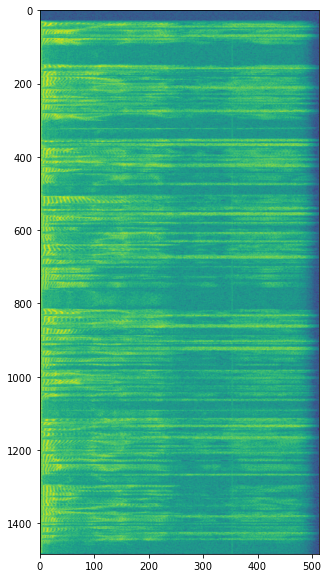

In [141]:
spectrogram = tfio.experimental.audio.spectrogram(
    tensor, nfft=1024, window=1024, stride=256)

fig,ax = plt.subplots(figsize=(5,10))
ax.imshow(tf.math.log(spectrogram).numpy(),aspect='auto')
# ax.set_axis_off()

In [19]:
train_test_df[train_test_df['native_language']== 'spanish']

,Unnamed: 0,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,train_test_none
1004,1785,24.0,17.0,"caracas, venezuela",spanish1,spanish,male,323,venezuela,False,train
1005,1786,48.0,47.0,"san luis de la reina, el salvador",spanish10,spanish,male,324,el salvador,False,train
1006,1787,30.0,26.0,"iquitos, peru",spanish100,spanish,female,1508,peru,False,train
1007,1788,39.0,19.0,"la union, el salvador",spanish101,spanish,female,1574,el salvador,False,train
1008,1789,31.0,26.0,"cochabamba, bolivia",spanish102,spanish,male,1575,bolivia,False,train
...,...,...,...,...,...,...,...,...,...,...,...
1161,1942,31.0,21.0,"juarez, mexico",spanish95,spanish,female,1444,mexico,False,test
1162,1943,29.0,12.0,"arequipa, peru",spanish96,spanish,female,1449,peru,False,test
1163,1944,52.0,19.0,"bogota, colombia",spanish97,spanish,female,1450,colombia,False,train
1164,1945,34.0,29.0,"veracruz, mexico",spanish98,spanish,male,1451,mexico,False,train
